<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>House price estimation with multiple input</h1>
</div>

In this notebook, you will see how to use the functional Keras API to implement a regressor with neural networks wich receive as input differents data types. This is a continuation of the previous notebook where only numerical data type was used. In this new one I will use both house image data and numerical data to house price estimation.

## Content

1. Load the Data
    - Import libraries.
    - Load the datasets.
    
2. Overview of the Data.
    - Descriptive Statistics.
    - Missing Values.
    
3. Exploratory Data Analysis.
    - Create a list of columns by data type.
    - Check the distribution of target class
    - Check the distribution of every feature.
    
4. Data Preparation.
    - Data Cleaning.
    - Feature encoding.
    - Split X & Y
    - Feature Scaling.
    
5. Model Building.
    - Defining the model.
    - Train model.
    - Model prediction.
    - Model evaluation.

6. Improve the model.
    - Handle the outlier values.
    - Scaling the data.
    - Building the new model.
    - Training the new model.
    - Model prediction.
    - Model evaluation.
    - Saving the model.

7. Conclusions.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>

In this section you will:

- Import the libraries.
- Load the dataset.

### 1.1 Import Libraries

In [1]:
#Import libraries

import os

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Image Manipulation 
import cv2

#Data Manipulation
import pandas as pd
import numpy as np


### 1.2 Load the datasets

In the previous notebook a processed dataset was generated, I am going to use that dataset to feed the model and to get the images

In [2]:
#dataset path
#change this path for you data path
num_data_path = "output/final_house_price_prediction.csv"
image_data_path = "../../../Houses-dataset/Houses-Dataset/"

#read the data
df = pd.read_csv(num_data_path)
df.head()

,Unnamed: 0,z_91901,z_92276,z_92677,z_92880,z_93446,z_93510,z_94501,z_94531,bedrooms,bathrooms,area,price
0,32,0,0,0,0,1,0,0,0,3,2.0,1802,365000
1,39,0,0,0,0,1,0,0,0,3,3.0,2146,455000
2,80,1,0,0,0,0,0,0,0,4,2.5,2464,599000
3,81,1,0,0,0,0,0,0,0,2,2.0,1845,529800
4,82,1,0,0,0,0,0,0,0,2,1.0,1184,397500


In [3]:
#change the column called "unnamed" which represents the house number
df.rename(columns={'Unnamed: 0':"idx"}, inplace= True)
df.head()

,idx,z_91901,z_92276,z_92677,z_92880,z_93446,z_93510,z_94501,z_94531,bedrooms,bathrooms,area,price
0,32,0,0,0,0,1,0,0,0,3,2.0,1802,365000
1,39,0,0,0,0,1,0,0,0,3,3.0,2146,455000
2,80,1,0,0,0,0,0,0,0,4,2.5,2464,599000
3,81,1,0,0,0,0,0,0,0,2,2.0,1845,529800
4,82,1,0,0,0,0,0,0,0,2,1.0,1184,397500


In [4]:
#lets to create an array to content the image data

def stack_images(ims):
    
    ims = [cv2.resize(im,(120,120)) for im in ims]
    im1 = np.hstack((ims[0],ims[1]))
    im2 = np.hstack((ims[2],ims[3]))
    im = np.vstack((im1,im2))
    return im
    
    

def load_images(image_path, idx_list):
    
    images = os.listdir(image_path)
    images = [im for im in images if im.split(".")[-1] =="jpg" and int(im.split("_")[0]) in idx_list]
    images.sort()
    
    ims = []
    image_dataset = []
    for n in range(len(images)):
        ims.append(cv2.imread(os.path.join(image_path,images[n])))
        if len(ims)==4:
            idx = images[n].split("_")[0]
            image_dataset.append([idx,stack_images(ims)])
            ims = []
    
    return image_dataset
    
    

In [5]:
image_dataset = load_images(image_data_path, df.idx.values)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Overview of the Data.</h2>
</div>

The dataset I'll use for this project can be found in the next [link](https://github.com/emanhamed/Houses-dataset), this dataset contains both visual and textual information for house prices estimation. Each house in the dataset is represented by four images for bedroom, bathroom, kitchen and frontal image of the house. 

The dataset also contains a text file with textual metadata, each row represents the number of houses in order. The numbers represent the number of bedrooms, number of bathrooms, area of the house, zip code and the price.

This dataset was processed in the previous notebook, in this one I am going to focus more in the image dataset

### 2.1 Image dataset

Let's see how our image dataset looks


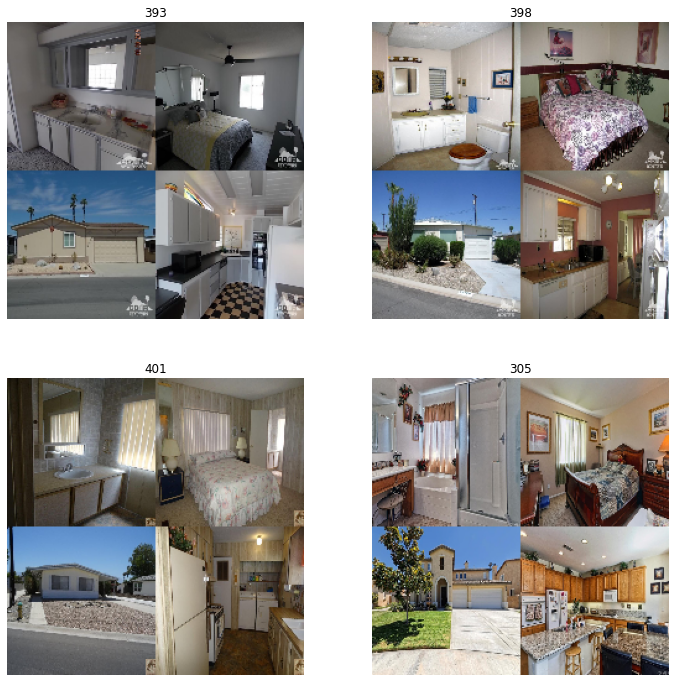

In [6]:
fig, axs = plt.subplots(2,2,figsize = (12,12))
for axi in axs:
    for ax in axi:
        idx = np.random.randint(len(image_dataset))
        ax.imshow(cv2.cvtColor(image_dataset[idx][1], cv2.COLOR_BGR2RGB))
        ax.set_title(image_dataset[idx][0])
        ax.axis("off")

In the figure above we can see how the images represent four different houses. We can see the index in the house as well, I will use it to link with the respective rows in the dataframe.

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3.Create the dataset.</h2>
</div>

In this scenario we have a dataset formed by two kind of data, I am going to create an array to link this types of data.

In [7]:
def create_dataset(image_dataset, num_dataset=None):
    
    X_num = []
    X_im = []
    Y = []
    for idx, im in image_dataset:
        X_num += [num_dataset[num_dataset["idx"] == int(idx)].values.flatten()[0:-1]]
        X_im += [im/255.]
        Y.append(num_dataset[num_dataset["idx"] == int(idx)].values.flatten()[-1])
    
    return X_num,X_im, Y
    

In [8]:
df = df.sample(frac = 1).reset_index(drop = False)
X_num, X_im, Y = create_dataset(image_dataset, df)

X_num = np.array(X_num)
X_im = np.array(X_im)
Y = np.array(Y)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Train test split</h2>
</div>



I will split the data into training and testing data sets, also I am going to scale the numerical data.

In [9]:
train_size = int(0.8 * len(X_num))

X_num_train = X_num[0:train_size]
X_im_train = X_im[0:train_size]
Y_train = Y[0:train_size]

X_num_test = X_num[train_size:]
X_im_test = X_im[train_size:]
Y_test = Y[train_size:]

#scaling the data
scaler = MinMaxScaler()

X_num_train_scaled = scaler.fit_transform(X_num_train)
Y_train_scaled = Y_train/max(Y_train)

X_num_test_scaled = scaler.transform(X_num_test)
Y_test_scaled = Y_test/max(Y_train)


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Model building</h2>
</div>

### 5.1 Defining the model.

In this scenario I will need to create a special neural network architecture so I will be able to feed it using both types of data that we have

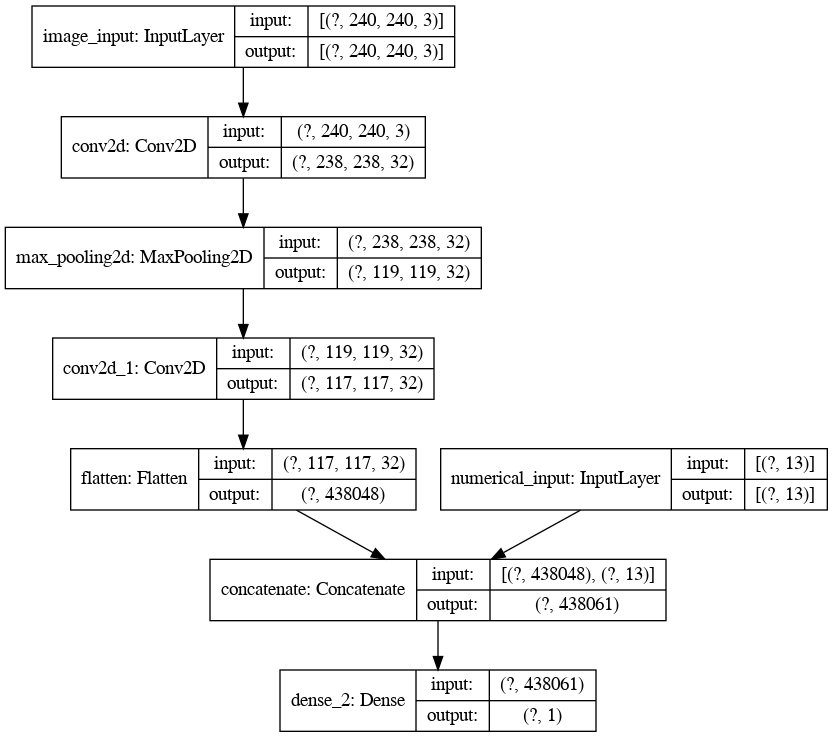

In [10]:
def create_model(input_num_shape, input_image_shape):

    #Numerical input layer
    input_num_layer = Input(shape = input_num_shape, name ="numerical_input")
    #first_dense_num = Dense(16, activation = "relu")(input_num_layer)
    #second_dense_num = Dense(8, activation = "relu")(first_dense_num)
    
    # Image input layer 
    input_image_layer = Input(shape= input_image_shape, name ="image_input")
    
    #Convolutional layers -> image
    conv_1 = Conv2D(32,3,activation = "relu")(input_image_layer)
    max_pooling_1 = MaxPool2D((2,2))(conv_1)
    conv_2 = Conv2D(32,3, activation = "relu")(max_pooling_1)
    max_pooling_2 = MaxPool2D((2,2))(conv_2)
    conv_3 = Conv2D(16,3, activation = "relu")(max_pooling_2)
    flatten = Flatten()(conv_2)
    
    #combining the two ways
    mix_layer = Concatenate()([flatten, input_num_layer])
    
    #dense layers
    first_dense = Dense(16, activation = "relu")(mix_layer)
    second_dense = Dense(8, activation = "relu")(first_dense)
    
    #last layer (regression output)
    last_layer = Dense(1, activation ="linear")(mix_layer)

    #creating the model
    model = Model(inputs = [input_num_layer, input_image_layer], outputs = last_layer)
    
    return model

model = create_model(input_num_shape=X_num_train.shape[1], input_image_shape = X_im_train.shape[1:])

#plot model
plot_model(model, show_shapes=True)

### 5.2 Train the model.

To train the model I need to use the compile method to define the loss function and the metric to be used.

In [11]:
#use adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001)

#use mean absolute error as loss function
model.compile(optimizer= optimizer, loss="mae")

#train the model
history = model.fit(
    x = (X_num_train_scaled,X_im_train),
    y = Y_train_scaled,
    epochs = 200,
    validation_data = ((X_num_test_scaled,X_im_test),Y_test_scaled),
    batch_size = 16,
    verbose = 1
)

Epoch 1/200
16/16 [==============================] - 14s 852ms/step - loss: 2.5454 - val_loss: 0.3086
Epoch 2/200
16/16 [==============================] - 9s 591ms/step - loss: 0.4048 - val_loss: 0.3639
Epoch 3/200
16/16 [==============================] - 9s 564ms/step - loss: 0.2858 - val_loss: 0.2852
Epoch 4/200
16/16 [==============================] - 9s 565ms/step - loss: 0.2348 - val_loss: 0.2061
Epoch 5/200
16/16 [==============================] - 9s 570ms/step - loss: 0.1671 - val_loss: 0.1816
Epoch 6/200
16/16 [==============================] - 9s 562ms/step - loss: 0.1190 - val_loss: 0.2047
Epoch 7/200
16/16 [==============================] - 9s 565ms/step - loss: 0.0961 - val_loss: 0.2082
Epoch 8/200
16/16 [==============================] - 9s 571ms/step - loss: 0.0873 - val_loss: 0.1906
Epoch 9/200
16/16 [==============================] - 9s 562ms/step - loss: 0.0883 - val_loss: 0.1933
Epoch 10/200
16/16 [==============================] - 9s 565ms/step - loss: 0.0704 - val_l

16/16 [==============================] - 9s 564ms/step - loss: 0.0225 - val_loss: 0.1827
Epoch 82/200
16/16 [==============================] - 9s 559ms/step - loss: 0.0196 - val_loss: 0.1845
Epoch 83/200
16/16 [==============================] - 9s 567ms/step - loss: 0.0203 - val_loss: 0.1769
Epoch 84/200
16/16 [==============================] - 9s 564ms/step - loss: 0.0205 - val_loss: 0.1799
Epoch 85/200
16/16 [==============================] - 9s 563ms/step - loss: 0.0167 - val_loss: 0.1802
Epoch 86/200
16/16 [==============================] - 9s 564ms/step - loss: 0.0163 - val_loss: 0.1791
Epoch 87/200
16/16 [==============================] - 9s 572ms/step - loss: 0.0181 - val_loss: 0.1758
Epoch 88/200
16/16 [==============================] - 9s 566ms/step - loss: 0.0200 - val_loss: 0.1786
Epoch 89/200
16/16 [==============================] - 9s 564ms/step - loss: 0.0181 - val_loss: 0.1748
Epoch 90/200
16/16 [==============================] - 9s 562ms/step - loss: 0.0188 - val_loss: 

Epoch 161/200
16/16 [==============================] - 9s 563ms/step - loss: 0.0106 - val_loss: 0.1604
Epoch 162/200
16/16 [==============================] - 9s 561ms/step - loss: 0.0111 - val_loss: 0.1585
Epoch 163/200
16/16 [==============================] - 9s 565ms/step - loss: 0.0093 - val_loss: 0.1595
Epoch 164/200
16/16 [==============================] - 9s 560ms/step - loss: 0.0110 - val_loss: 0.1626
Epoch 165/200
16/16 [==============================] - 9s 559ms/step - loss: 0.0110 - val_loss: 0.1620
Epoch 166/200
16/16 [==============================] - 9s 566ms/step - loss: 0.0113 - val_loss: 0.1638
Epoch 167/200
16/16 [==============================] - 9s 577ms/step - loss: 0.0106 - val_loss: 0.1602
Epoch 168/200
16/16 [==============================] - 9s 561ms/step - loss: 0.0114 - val_loss: 0.1595
Epoch 169/200
16/16 [==============================] - 9s 561ms/step - loss: 0.0112 - val_loss: 0.1583
Epoch 170/200
16/16 [==============================] - 9s 562ms/step - lo

In [12]:
X_im_test.shape, X_im_train.shape

((62, 240, 240, 3), (245, 240, 240, 3))

Now let's look at the training process history, we can see that both the loss metric and the root mean squared error are high at the beginning and decrease gradually through the epochs, we can notice how the validation metric is always higher than the metric obtained with the training data.

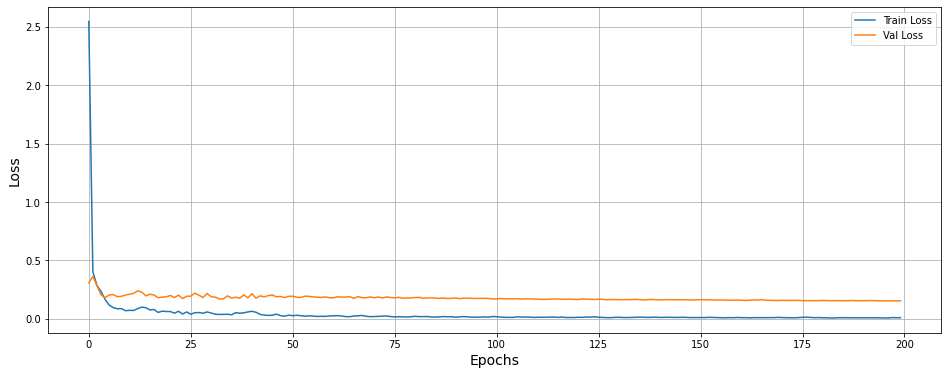

In [13]:
plt.figure(figsize=(16,6))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid()
plt.legend(loc = "best")

### 5.3 Model prediction

In this case let's do some manipulations before to start with the predictions.

In [14]:
#Getting predictions on test data
predictions = model.predict([X_num_test_scaled,X_im_test]).flatten()

#transforming the data to the normal scale
max_price = max(Y_train)
predictions = predictions * max_price

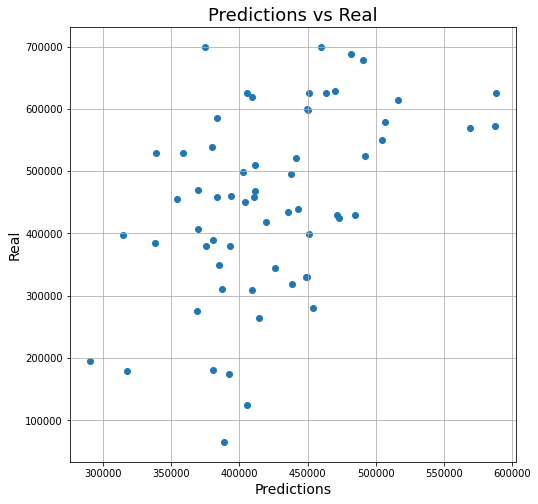

In [15]:
plt.figure(figsize = (8,8))
plt.scatter(predictions, Y_test)
plt.title("Predictions vs Real", fontsize = 18)
plt.xlabel("Predictions", fontsize = 14)
plt.ylabel("Real", fontsize = 14)
plt.grid()

In the figure above we can see how the model predicts the majority of the values, however, there are some values which do not match with the prediction.

### 5.4 Model evaluation

Let's use some commun metrics used to evaluate regression models, this will be:

+ Mean Absolute Error (MAE)
+ Root Mean Squared Error (RMSE)

In [16]:
#error
error = predictions-Y_test

#mean absolute error 
mae = np.round(np.mean(np.abs(error)),2)

#root mean squared error
rmse = np.round(np.sqrt(np.mean(np.square(error))),2)

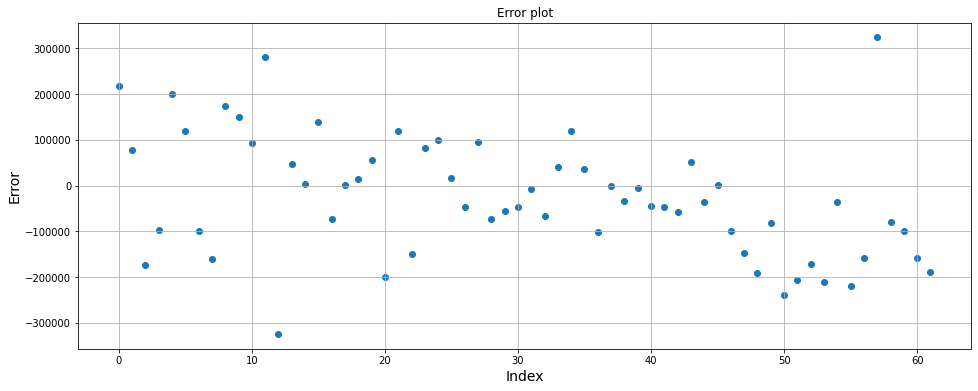

In [17]:
#error plot
plt.figure(figsize = (16,6))
plt.scatter(range(len(Y_test)), error)
plt.ylabel("Error", fontsize = 14)
plt.xlabel("Index", fontsize = 14)
plt.title("Error plot")
plt.grid()

In [18]:
print(f"MAE: {mae} RMSE: {rmse}")

MAE: 108860.01 RMSE: 134681.45


The MAE is around $ 100 k this implies a poor performance, however if we do not take into account the big values the performance would be better, for example, let's use the median instead of the mean value to calculate a new metric.

In [19]:
mdae = np.round(np.median(np.abs(error)),2)

print(f"MDAE: {mdae}")

MDAE: 96141.48


Since the median is more robust against anomalous values we have a better metric value, however we need to improve this model. 

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6. Improve the model.</h2>
</div>

### 6.1 Handle the outlier values

Let's remove the outlier values to improve the model performance. Let's remove all the houses with price higher than $ 700 k

In [20]:
df2 = df[(df["price"]<= 700000) & (df["area"]<=8000) & (df["bedrooms"]<=7)]

df2.shape

(307, 14)

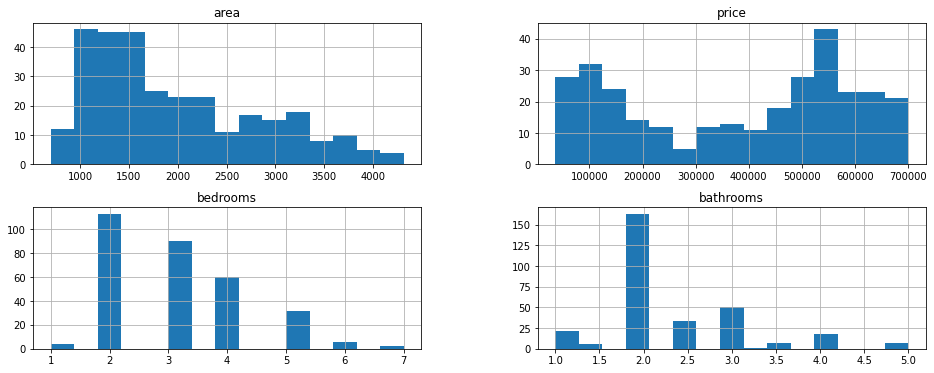

In [21]:
# Check the distribution of the area and price columns
df2[["area","price", "bedrooms","bathrooms"]].hist(figsize=(16,6),bins = 15)
plt.show()

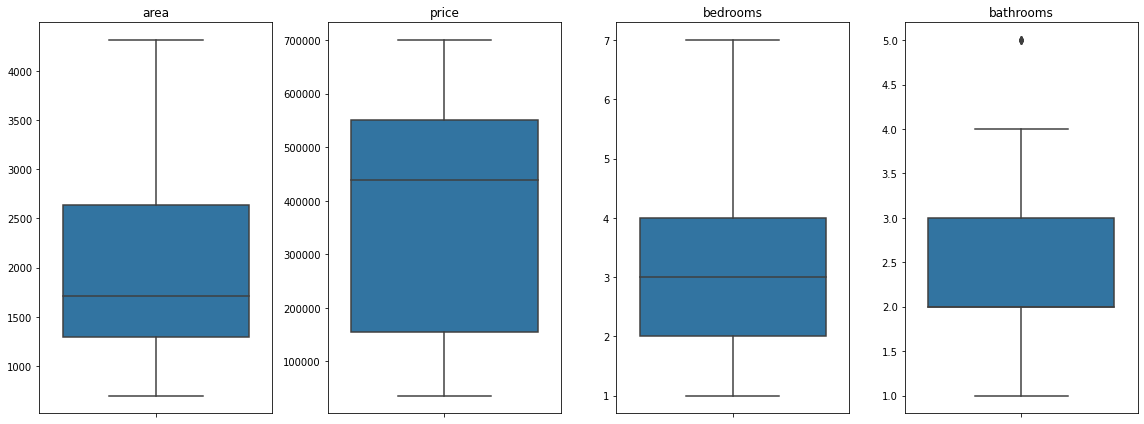

In [22]:
# Check the distribution of each variable
fig,ax = plt.subplots(nrows = 1, ncols = 4, figsize=(16,6))
for i,label in enumerate(["area","price", "bedrooms","bathrooms"]):
    sn.boxplot(x = df2[label].values, orient = "v" ,ax = ax[i])
    ax[i].set_title(label)
    
plt.tight_layout()
plt.show()

### 6.2 Scaling the data

In [23]:
processed_df2 = scaling_splitting_data(df2)

NameError: name 'scaling_splitting_data' is not defined

### 6.3 Building new model

In [ ]:
model2 = create_model(processed_df2)

### 6.4 Training the new model.

In [ ]:
#use adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=0.001)

#use mean absolute error as loss function
model2.compile(optimizer= optimizer, loss="mae")

#train the model
history_model2 = model2.fit(
    x = processed_df2["x_train_scaled"],
    y = processed_df2["y_train_scaled"],
    epochs = 200,
    validation_data = (processed_df2["x_test_scaled"], processed_df2["y_test_scaled"]),
    batch_size = 16,
    verbose = 0
)

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(history_model2.history["loss"], label = "Train Loss")
plt.plot(history_model2.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
plt.grid()
plt.legend(loc = "best")

### 6.5 Model prediction

In [ ]:
#Getting predictions on test data
predictions2 = model2.predict(processed_df2["x_test_scaled"]).flatten()

#transforming the data to the normal scale
max_price2 = max(processed_df2["y_train"])
predictions2 = predictions2 * max_price2

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(predictions2, processed_df2["y_test"])
plt.title("Predictions vs Real", fontsize = 18)
plt.xlabel("Predictions", fontsize = 14)
plt.ylabel("Real", fontsize = 14)
plt.grid()

### 6.6 Model evaluation.

In [ ]:
#error
error2 = predictions2-processed_df2["y_test"]

#mean absolute error 
mae2 = np.round(np.mean(np.abs(error2)),2)

#root mean squared error
rmse2 = np.round(np.sqrt(np.mean(np.square(error2))),2)

In [ ]:
#error plot
plt.figure(figsize = (16,6))
plt.scatter(error2.index, error2.values)
plt.ylabel("Error", fontsize = 14)
plt.xlabel("Index", fontsize = 14)
plt.title("Error plot")
plt.grid()

In [ ]:
print(f"MAE: {mae2} RMSE: {rmse2}")

In [ ]:
mdae2 = np.round(np.median(np.abs(error2)),2)

print(f"MDAE: {mdae2}")

In [ ]:
#Save the final data set used
df2.to_csv("output/final_house_price_prediction.csv", index = True)

### 6.7 Saving the final model.

In [ ]:
model2.save("output/house_price_regressor")

### 7. Conclusions

In this notebook we saw how to use the functional API of tensorflow to solve a regression problem. We also noticed how the presence of outliers affects the model performance. In the next part I am going to include the house image data to improve the house price prediction.